In [2]:
import sys
sys.path.append('../../code/')

In [3]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs.visuals import grid
from libs import helpers
# from libs.metrics import aggregators
from libs.metrics import helpers as helpers_metrics
from libs.visuals import polar_infra
from libs.visuals import constants as grid_constants
# from libs import latex

Available LLMs: (24): llama-3.3-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [4]:
APS_OA_DATA_TAR_GZ = '../../../APS/data/final_dataset.tar.gz'
APS_OS_DISCIPLINE_DEMOGRAPHICS = '../../results/interventions/metadata/disciplines_author_demographics.csv'
FN_COAUTHORSHIP = '../../../APS/results/augmented_aps/coauthorships.csv'


In [5]:
SUMMARY_PATH = '../../results/interventions/summaries'
VALID_RESPONSES_PATH = '../../results/interventions/valid_responses'
FACTUALITY_PATH = '../../results/interventions/factuality'
SIMILARITY_PATH = '../../results/interventions/similarities'

PLOTS_PATH = '../../results/interventions/plots'
TABLES_PATH = '../../results/interventions/tables'
LATEX_PATH = '../../results/interventions/latex'

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)

In [6]:
vis.sns_reset()
vis.sns_paper_style(font_scale=1.55)

## Data

In [6]:
# Load the summary data for each model (all outputs)
df_summary_all = io.pd.concat([io.read_csv(io.path_join(SUMMARY_PATH, f"experiments_{model}.csv"), low_memory=False) for model in constants.LLMS], ignore_index=True)
df_valid_responses_all = io.pd.concat([io.read_csv(io.path_join(VALID_RESPONSES_PATH, f"{model}.csv"), index_col=0, low_memory=False) for model in constants.LLMS], ignore_index=True)
df_factuality_author_all = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_author.csv"), index_col=0, low_memory=False) for model in constants.LLMS], ignore_index=True)

df_similarity_all = io.pd.DataFrame()
for model in constants.LLMS:
    for fn in io.glob.glob(io.path_join(SIMILARITY_PATH, f"{model}_*.csv")):
        tmp = io.read_csv(fn, low_memory=False, index_col=0)
        df_similarity_all = io.pd.concat([df_similarity_all, tmp], ignore_index=True)


df_summary_all.shape, df_valid_responses_all.shape, df_factuality_author_all.shape, df_similarity_all.shape 
# (72117, 20)

((72117, 20), (3365532, 17), (3365532, 36), (20585, 27))

In [7]:
# filter period (valid for open-weight models)
# 2026-01-15 some models were not available (eg. gemma, qwen)
start_date = '2025-12-19'
end_date = '2026-01-18'

# filter out interventions
query = "((not model.str.contains('gemini') and date >= @start_date and date <= @end_date) or model.str.contains('gemini'))"

df_summary = df_summary_all.query(query).copy()
df_valid_responses = df_valid_responses_all.query(query).copy()
df_factuality_author = df_factuality_author_all.query(query).copy()
df_similarity = df_similarity_all.query(query).copy()

# shapes
df_summary.shape, df_valid_responses.shape, df_factuality_author.shape, df_similarity.shape


((65997, 20), (3196771, 17), (3196771, 36), (19532, 27))

In [8]:
# demographics
df_all_authors_demographics = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_DEMOGRAPHICS_FN)
df_all_authors_demographics.rename(columns={'id_author':'id_author_oa'}, inplace=True)

# scholarly stats
df_all_authors_stats = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_STATS_FN)
df_all_authors_stats.rename(columns={'id_author':'id_author_oa'}, inplace=True)

# per discipline
df_gt_stats = io.read_csv(APS_OS_DISCIPLINE_DEMOGRAPHICS, index_col=0, header=[0, 1])

# coauthorships
df_coauthorships = io.pd.read_csv(FN_COAUTHORSHIP, index_col=0)
oa_ids_in_recommendations = df_factuality_author.id_author_oa.unique()
df_coauthorships_in_recommendations = df_coauthorships.query("src in @oa_ids_in_recommendations and dst in @oa_ids_in_recommendations and src != dst").copy()

# gt (from APS)
df_gt = df_all_authors_demographics[['id_author_oa','first_name','last_name','ethnicity','gender']].copy()
df_gt = df_gt.merge(df_all_authors_stats[['id_author_oa','works_count','cited_by_count', 'rr1_rank_publications','rr1_rank_publications_percentile', 'rr2_rank_citations','rr2_rank_citations_percentile']], on='id_author_oa', how='left')
df_gt = helpers.add_quantiles(df_gt)

# shapes
df_all_authors_demographics.shape, df_gt_stats.shape, df_gt_stats.shape, df_coauthorships_in_recommendations.shape, df_gt.shape

((481012, 14), (17, 19), (17, 19), (350554, 2), (481012, 13))

In [9]:
df_gt.gender.value_counts(normalize=True) * 100

gender
Male       44.432779
Unknown    42.221192
Female      8.772130
Unisex      4.573898
Name: proportion, dtype: float64

## Augmenting data

In [10]:
# adding prominence metrics to recommended authors
df_factuality_author = df_factuality_author.merge(df_gt[['id_author_oa', 'prominence_pub', 'prominence_cit']], on='id_author_oa', how='left')

# adding infrastructure metadata
df_summary = helpers.add_infrastructure_columns(df_summary)
df_factuality_author = helpers.add_infrastructure_columns(df_factuality_author)

# shapes
df_summary.shape, df_factuality_author.shape


((65997, 25), (3196771, 43))

# Metrics

In [22]:
# computes the metric per attempt for ALL requests

_ = helpers_metrics.load_per_attempt('validity_pct', df_summary, TABLES_PATH)
_ = helpers_metrics.load_per_attempt('refusal_pct', df_summary, TABLES_PATH)
_ = helpers_metrics.load_per_attempt('duplicates', df_factuality_author, TABLES_PATH)
_ = helpers_metrics.load_per_attempt('consistency', df_factuality_author, TABLES_PATH)

_ = helpers_metrics.load_per_attempt('factuality_author', df_factuality_author, TABLES_PATH)
_ = helpers_metrics.load_per_attempt('connectedness', df_factuality_author, TABLES_PATH, df_similarity=df_similarity, metric_similarity='recommended_author_pairs_are_coauthors')
_ = helpers_metrics.load_per_attempt('similarity', df_factuality_author, TABLES_PATH, df_similarity=df_similarity, metric_similarity='scholarly_similarity')

_ = helpers_metrics.load_per_attempt('diversity_gender', df_factuality_author, TABLES_PATH)
_ = helpers_metrics.load_per_attempt('diversity_ethnicity', df_factuality_author, TABLES_PATH)
_ = helpers_metrics.load_per_attempt('diversity_prominence_pub', df_factuality_author, TABLES_PATH)
_ = helpers_metrics.load_per_attempt('diversity_prominence_cit', df_factuality_author, TABLES_PATH)

_ = helpers_metrics.load_per_attempt('parity_gender', df_factuality_author, TABLES_PATH, gt=df_gt)
_ = helpers_metrics.load_per_attempt('parity_ethnicity', df_factuality_author, TABLES_PATH, gt=df_gt)
_ = helpers_metrics.load_per_attempt('parity_prominence_pub', df_factuality_author, TABLES_PATH, gt=df_gt)
_ = helpers_metrics.load_per_attempt('parity_prominence_cit', df_factuality_author, TABLES_PATH, gt=df_gt)


[2026-01-29 02:00:19] Data successfully saved to ../../results/interventions/tables/per_attempt_connectedness.csv
[2026-01-29 02:00:19] Data successfully saved to ../../results/interventions/tables/per_attempt_similarity.csv


# Plots

In [7]:
PREFIX = 'infrastructure'

In [8]:
# filter out interventions
query_infra = "task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded == False"

# Summary table

In [9]:
df_summary_infrastructure_attempt, df_summary_infrastructure_group = helpers_metrics.load_infrastructure_data(query_infra, TABLES_PATH, prefix=PREFIX)
df_summary_infrastructure_attempt.shape, df_summary_infrastructure_group.shape

((279893, 14), (120, 11))

## Overall performance per model group

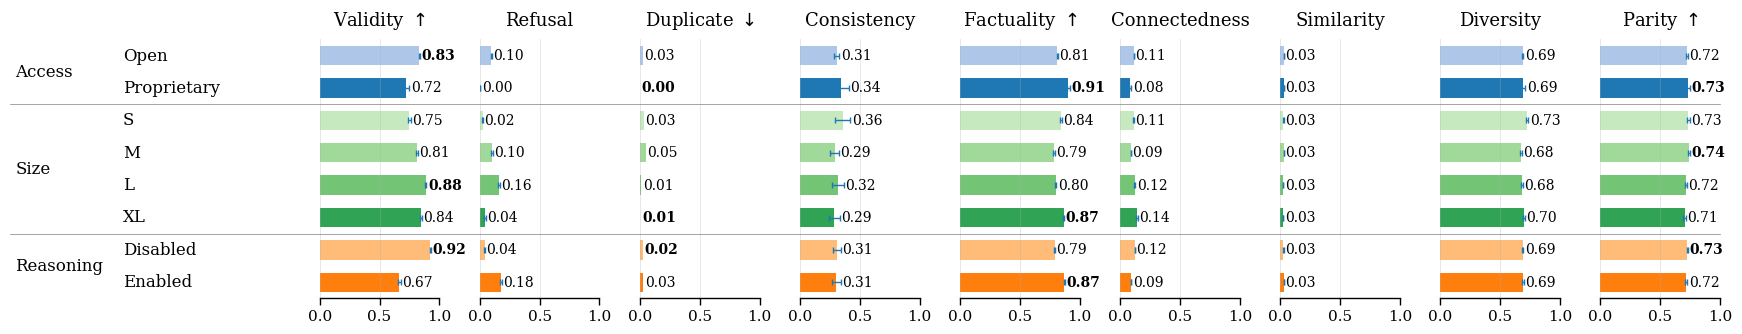

In [10]:
width_ratios = grid.width_ratios_for_split(k_panels=len(grid_constants.PANEL_INFRASTRUCTURE), bars_share=0.80, panel_ratio=0.9)

# Example:
fig = grid.plot_metric_grid_bars(
    df_summary_infrastructure_group,
    panels=grid_constants.PANEL_INFRASTRUCTURE,
    group_order=grid_constants.GROUPS_ORDER,
    model_order_within_group=grid_constants.MODEL_KIND_ORDER_WITHIN_GROUP,
    group_label_map=grid_constants.GROUP_LABEL_MAP,
    model_label_map=grid_constants.MODEL_KIND_LABEL_MAP,
    group_colors=grid_constants.GROUP_COLORS,
    layout=grid.LayoutSpec(figsize=(18, 3.5), wspace=0.30, separator_lw=0.5, label_ratio=0.5, panel_ratio=3),
    style=grid.StyleSpec(bar_height=0.6, title_fontsize=13, label_fontsize=12, tick_fontsize=11, value_fontsize=10),
    xlim=(0, 1),                 # global override
    xticks=[0, 0.5, 1.0],         # global override
    highlight_rules=grid_constants.METRIC_HIGHLIGHT_RULES,
    width_ratios=width_ratios,
)

fn = io.path_join(PLOTS_PATH, f'{PREFIX}_by_model_group.pdf')
fig.savefig(fn, dpi=constants.FIG_DPI, bbox_inches='tight')

grid.plt.show()
grid.plt.close()


## Overal performance per model

In [39]:
cols_group = ['model', 'grounded', 'temperature', 'task_name', 'task_param', 'metric_name']
per_attempt_data = df_summary_infrastructure_attempt.groupby(cols_group)['metric_value'].agg(['mean', 'std']).reset_index()
per_attempt_data = per_attempt_data.fillna(value={'std':0}).dropna(subset=['mean'])

per_attempt_data.loc[:, 'metric_group'] = per_attempt_data.metric_name.apply(lambda x: x.split('_')[0])
per_attempt_data.loc[:, 'metric_name'] = per_attempt_data.metric_name.apply(lambda x: x.split('_')[-1] if len(x.split('_')) > 1 else x)

per_attempt_data.head(2)

,model,grounded,temperature,task_name,task_param,metric_name,mean,std,metric_group
0,deepseek-chat-v3.1,False,0.0,epoch,1950s,connectedness,0.037580,0.013575,connectedness
1,deepseek-chat-v3.1,False,0.0,epoch,1950s,consistency,0.485875,0.000000,consistency


In [40]:
# models' metadata
df_models_metadata = io.pd.DataFrame(constants._llm_metadata.values())
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.model.str.split('/').str[-1].str.replace('-instruct', '').str.replace('-it', '')
df_models_metadata.loc[:, 'model_access'] = df_models_metadata.model.apply(lambda x: 'propietary' if 'gemini' in x else 'open')
df_models_metadata.loc[:, 'model_size'] = df_models_metadata['class'].apply(lambda x: x.split(' ')[0])
df_models_metadata.loc[:, 'model_class'] = df_models_metadata.reasoning.apply(lambda x: 'R' if x else 'NR')
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.apply(lambda row: f"{row.model_name}-grounded" if row.grounded == True else row.model_name, axis=1)
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.apply(lambda row: 'llama-4-mav' if row.model_name =='llama-4-maverick' else row.model_name, axis=1)
df_models_metadata.loc[0, 'model_name'] = 'llama-3.3-8b'
df_models_metadata.head(2)


,model,max_attempts,temperature,max_temperature,stop,stream,system_message_ref,provider,sub_provider,quantization,...,input_price,output_price,reasoning,class,class1,grounded,model_name,model_access,model_size,model_class
0,meta-llama/llama-3.1-8b-instruct,3,0.0,2,NaN,False,physics_research_assistant,openrouter,deepinfra/bf16,fp16,...,0.03,0.05,False,S,NaN,NaN,llama-3.3-8b,open,S,NR
1,meta-llama/llama-4-scout,3,1.0,2,NaN,False,physics_research_assistant,openrouter,deepinfra/fp8,fp8,...,0.08,0.30,False,L,NaN,NaN,llama-4-scout,open,L,NR


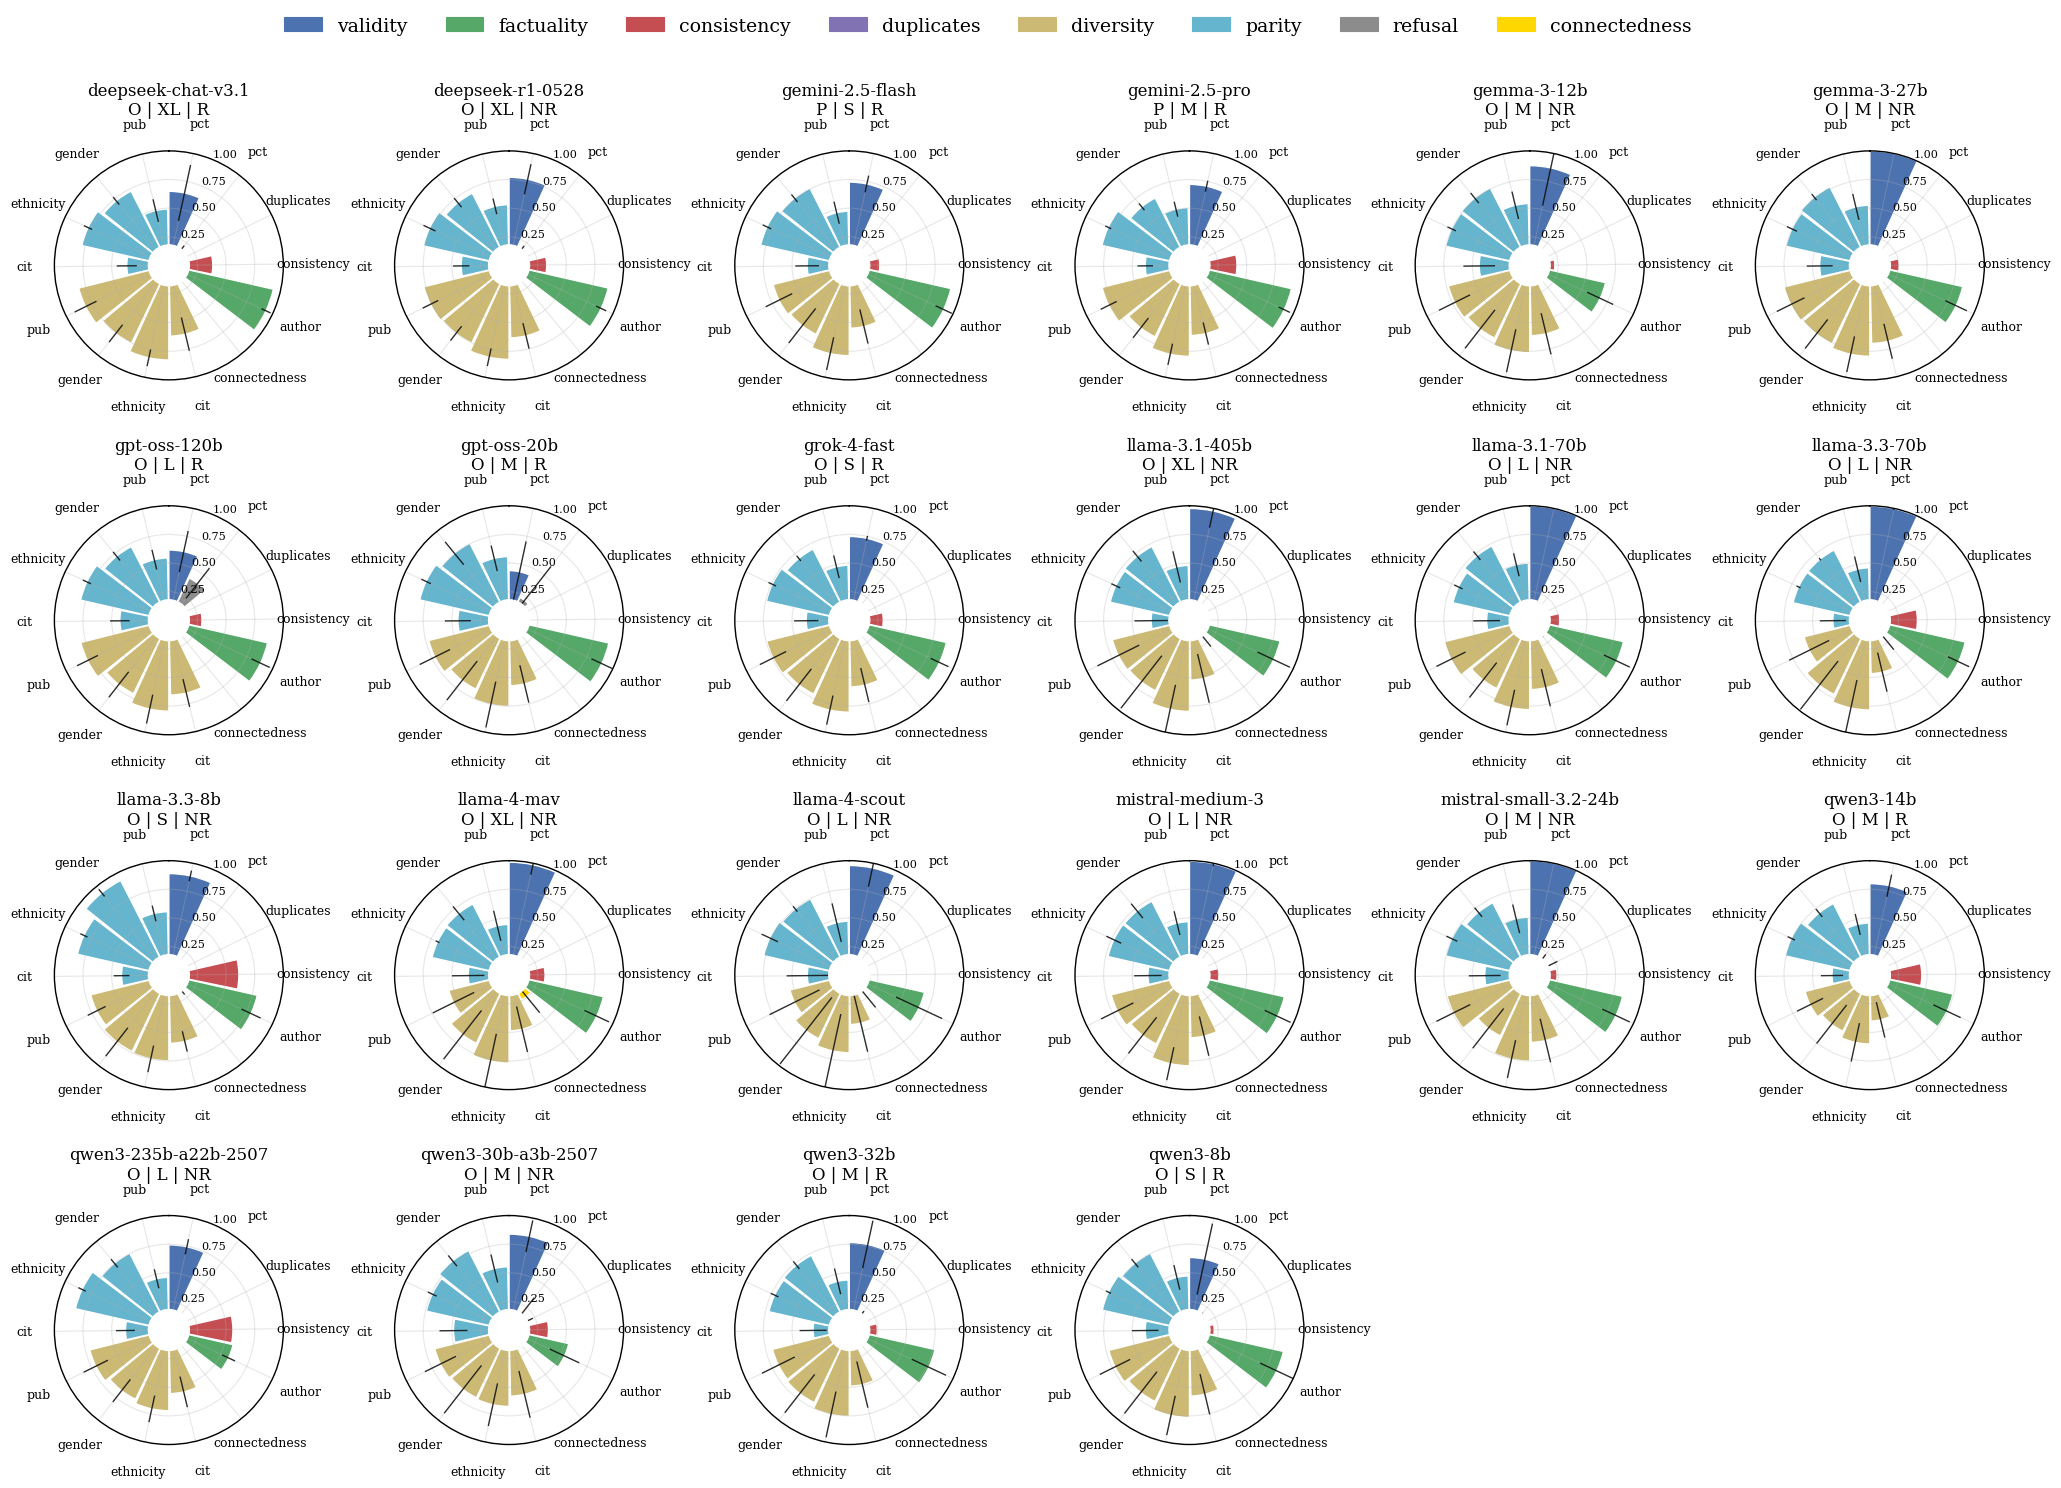

In [41]:
df_metrics = per_attempt_data.copy()

# order axis by metric
order = ["validity", "refusal", "duplicates", "consistency", "factuality",'connectedness', "diversity", "parity"]

# Define colors by metric_group (edit to match your groups exactly)
group_colors = {
            "validity": "#4C72B0",
            "factuality": "#55A868",
            "consistency": "#C44E52",
            "duplicates": "#8172B3",
            "diversity": "#CCB974",
            "parity": "#64B5CD",
            "refusal": "#8C8C8C",
            'connectedness': '#FFD700'
        }

fig = polar_infra.plot_model_grid(
    df_metrics=df_metrics,
    df_meta=df_models_metadata,
    meta_cols={"model": "model_name", "access": "model_access", "size": "model_size", "class": "model_class"},
    ncols=6,
    order=order,               # or your explicit list
    group_colors=group_colors,
    figsize_per_cell=(4.2, 4.2),
)

fig.savefig(io.path_join(PLOTS_PATH, 'infrastructure_by_model.pdf'), dpi=300, bbox_inches='tight')

polar_infra.plt.show()
polar_infra.plt.close()


# OLD

In [ ]:
FIGSIZE = (10, 2.)
FIGSIZE_TOP = (10, 2.15)
PLOT_KWARGS = {'figsize':FIGSIZE, 'ylim':(0, 1), 'show_xticks':True}
PLOT_KWARGS_D = {'figsize':FIGSIZE, 'ylim':(0, 0.06), 'show_xticks':True}
PLOT_KWARGS_M = {'figsize':FIGSIZE, 'ylim':(0, 0.5), 'show_xticks':True}
PLOT_KWARGS_H = {'figsize':FIGSIZE, 'ylim':(0, 0.2), 'show_xticks':True}
PLOT_KWARGS_TOP = {'figsize':FIGSIZE_TOP, 'ylim':(0, 1), 'show_title':True, 'show_xticks':True}



for metric in helpers_metrics.METRICS:
    fn = helpers_metrics.get_plot_fn(metric, PLOTS_PATH, prefix=PREFIX)
    per_attempt = helpers_metrics.load_per_attempt(metric, None, TABLES_PATH).query(query_infra)
    per_attempt = helpers.add_infrastructure_columns(per_attempt)

    kwargs = PLOT_KWARGS_TOP if metric == 'validity_pct' else PLOT_KWARGS_H if metric == 'refusal_pct' else PLOT_KWARGS_D if metric == 'duplicates' else PLOT_KWARGS_M if metric == 'consistency' else PLOT_KWARGS
    vis.plot_infrastructural_conditions(per_attempt, fn=fn, continuous=False, ylabel=metric, **kwargs)
